Here we train the convolutional neural network:
We require the following folders:
- DataFiltered: contains the filtered data by class and tranformed
- labels.csv: contains the labels of the data

What we first do is filter the data into training, test and validation sets. 

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil

c:\Users\Frank\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We filter the data into train/val/test in ratio 80|10|10.

In [2]:
labeling = pd.read_csv('labels.csv')
labeling

,filename,item_type,label
0,100_i110.png,100,plastic
1,100_i120.png,100,plastic
2,100_i130.png,100,plastic
3,100_i140.png,100,plastic
4,100_i150.png,100,plastic
...,...,...,...
5959,994_i180.png,994,"wood,paper"
5960,994_i190.png,994,"wood,paper"
5961,994_i210.png,994,"wood,paper"
5962,994_i230.png,994,"wood,paper"


In [3]:
unique_item_type = labeling['item_type'].unique()

In [4]:
item_shuffle = np.random.permutation(unique_item_type)
train_item_type = item_shuffle[:int(len(item_shuffle)*0.8)]
test_item_type = item_shuffle[int(len(item_shuffle)*0.8):int(len(item_shuffle)*0.9)]
val_item_type = item_shuffle[int(len(item_shuffle)*0.9):]

In [5]:
source_dir = './DataFiltered/'
target_dir = './trainvaltest/'

In [6]:
#remove the target directory if it exists
if (os.path.exists(target_dir)):
    shutil.rmtree(target_dir)

#make the target directory
os.mkdir(target_dir)

In [7]:
#copy files into train/val/test based on split
if (not os.path.exists(target_dir + "train") and not os.path.exists(target_dir + "val") and not os.path.exists(target_dir + "test")):
    os.mkdir(target_dir + "train")
    os.mkdir(target_dir + "val")
    os.mkdir(target_dir + "test")

for item in train_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "train/" + row['filename'])

for item in val_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "val/" + row['filename'])

for item in test_item_type:
    list_item = labeling[labeling['item_type'] == item]
    for index, row in list_item.iterrows():
        print(source_dir + row['filename'])
        shutil.copy(source_dir + row['filename'], target_dir + "test/" + row['filename'])

        

./DataFiltered/926_i110.png
./DataFiltered/926_i120.png
./DataFiltered/926_i130.png
./DataFiltered/926_i140.png
./DataFiltered/926_i150.png
./DataFiltered/926_i160.png
./DataFiltered/926_i170.png
./DataFiltered/926_i180.png
./DataFiltered/926_i190.png
./DataFiltered/926_i210.png
./DataFiltered/926_i230.png
./DataFiltered/926_i250.png
./DataFiltered/92_i110.png
./DataFiltered/92_i120.png
./DataFiltered/92_i130.png
./DataFiltered/92_i140.png
./DataFiltered/92_i150.png
./DataFiltered/92_i160.png
./DataFiltered/92_i170.png
./DataFiltered/92_i180.png
./DataFiltered/92_i190.png
./DataFiltered/92_i210.png
./DataFiltered/92_i230.png
./DataFiltered/92_i250.png
./DataFiltered/592_i110.png
./DataFiltered/592_i120.png
./DataFiltered/592_i130.png
./DataFiltered/592_i140.png
./DataFiltered/592_i150.png
./DataFiltered/592_i160.png
./DataFiltered/592_i170.png
./DataFiltered/592_i180.png
./DataFiltered/592_i190.png
./DataFiltered/592_i210.png
./DataFiltered/592_i230.png
./DataFiltered/592_i250.png
./Da

Training via Convolutional Neural Network:
But first we need to load the data into dataloaders

In [8]:
#frequency of each class in train/val/test
train_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
val_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}
test_freq = {"metal": 0, "plastic": 0, "wood,paper": 0}

for file in os.listdir(target_dir + "train"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    train_freq[material_type] += 1
for file in os.listdir(target_dir + "val"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    val_freq[material_type] += 1
for file in os.listdir(target_dir + "test"):
    material_type = labeling[labeling['filename'] == file]['label'].values[0]
    test_freq[material_type] += 1


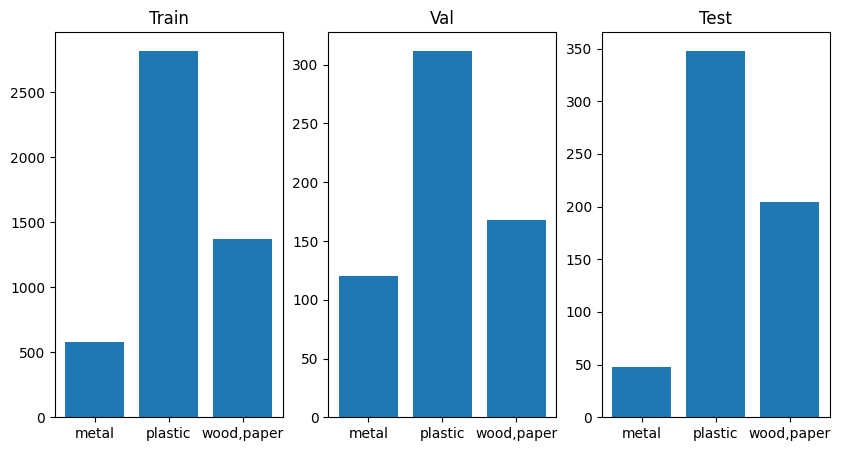

In [9]:
#plot frequency of each class in train/val/test
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.bar(train_freq.keys(), train_freq.values())
plt.title("Train")
plt.subplot(1, 3, 2)
plt.bar(val_freq.keys(), val_freq.values())
plt.title("Val")
plt.subplot(1, 3, 3)
plt.bar(test_freq.keys(), test_freq.values())
plt.title("Test")
plt.show()

In [10]:
#custom dataset class
class Top4Dataset(Dataset):
    def __init__(self, csv_file, root_dir, label, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform
        self.image_names = os.listdir(root_dir)
        self.label = label
    def __len__(self):
        return len(self.image_names)
    
    def __items_class__(self):
        return self.label
    def __getitem__(self, index):
        img_name = self.image_names[index]
        img_path = os.path.join(self.root_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        image = image.float()
        material_name = self.annotations[self.annotations["filename"] == img_name]["label"].values[0]
        y_label = [0.0, 0.0, 0.0]
        y_label[self.label[material_name]] = 1.0
        y_label = torch.tensor(y_label)
        path = img_name
        return (image, y_label, path)

In [11]:
material_label = {"metal": 0, "plastic": 1, "wood,paper": 2}

In [12]:
#data transforms
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((144,144)),
    transforms.ToTensor(),
])

In [13]:
Top4Dataset_train = Top4Dataset(csv_file='labels.csv', root_dir=target_dir + "train/", label=material_label, transform=data_transforms)
Top4Dataset_val = Top4Dataset(csv_file='labels.csv', root_dir=target_dir + "val/", label=material_label, transform=data_transforms)
Top4Dataset_test = Top4Dataset(csv_file='labels.csv', root_dir=target_dir + "test/", label=material_label, transform=data_transforms)

print(f"length of train dataset: {len(Top4Dataset_train)}")
print(f"length of val dataset: {len(Top4Dataset_val)}")
print(f"length of test dataset: {len(Top4Dataset_test)}")

length of train dataset: 4764
length of val dataset: 600
length of test dataset: 600


In [14]:
DataLoader_train = DataLoader(dataset=Top4Dataset_train, batch_size=8, shuffle=True)
DataLoader_val = DataLoader(dataset=Top4Dataset_val, batch_size=8, shuffle=True)
DataLoader_test = DataLoader(dataset=Top4Dataset_test, batch_size=8, shuffle=True)

In [15]:
label_list = ['metal', 'plastic', 'wood,paper']
DataLoader_train.dataset.__items_class__()

{'metal': 0, 'plastic': 1, 'wood,paper': 2}

IndexError: index 8 is out of bounds for dimension 0 with size 8

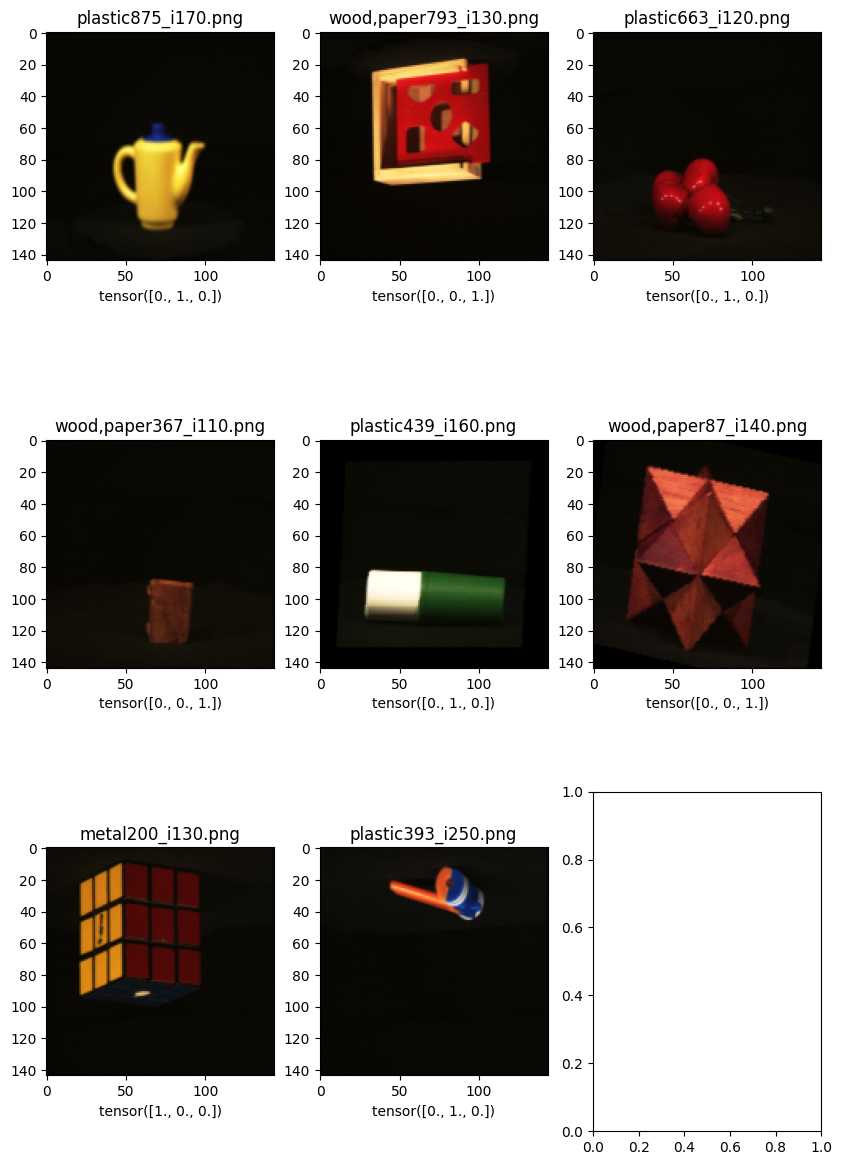

In [16]:
#show images
data = next(iter(DataLoader_train))
images, labels, path = data
plt.figure(figsize=(10, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i].permute(1,2,0))
    true_label = label_list[labels[i].argmax()]
    plt.title(true_label + path[i])
    plt.xlabel(labels[i])

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=5, padding=2),
            nn.LeakyReLU(),
            nn.AvgPool2d(kernel_size=3, stride=3),
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(46080, 124),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(124, 3),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        logits = nn.functional.normalize(x)
        logits = self.conv_relu_stack(x)
        logits = self.flatten(logits)
        logits = self.linear_relu_stack(logits)
        return logits

model = ConvNeuralNetwork().to(device)
print(model)

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    loss_result = 0
    for batch, (X, y, path) in enumerate(dataloader):
        # add noise to the image
        # Compute prediction error
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_result += loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_result/len(dataloader)

In [ ]:
class EarlyStopper():
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.losshistory = []
        self.trainlosshistory = []

    def early_stop(self, validation_loss, train_loss, nnmodel):
        self.losshistory.append(validation_loss)
        self.trainlosshistory.append(train_loss)
        if validation_loss < self.min_validation_loss:
            torch.save(model.state_dict(), "model.pt")
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss >= (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y, z) in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
weight = [6.0, 0.5, 2.0]
DataLoader_train.dataset.label

In [ ]:
#model parameters
learning_rate = 1e-3
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
#train model
early_stopping = EarlyStopper( patience=2, min_delta=0.0001)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train(DataLoader_train, model, loss_fn, optimizer)
    test_loss = test(DataLoader_test, model, loss_fn)
    early_stopping.early_stop(test_loss, train_loss, model)
    #if early_stopping.early_stop(test_loss, train_loss, model):
        #print("Early stopping")
        #break
print("Done!")

In [ ]:
plt.plot(early_stopping.losshistory, label='validation loss')
plt.plot(early_stopping.trainlosshistory, label='train loss')
plt.legend()